In [ ]:
!nvidia-smi

In [1]:
from google.colab import drive

drive.mount('./gdrive', force_remount=True)
%cd './gdrive/My Drive/Colab Notebooks/cubricks'

Mounted at ./gdrive
/content/gdrive/My Drive/Colab Notebooks/cubricks


## Modules

In [2]:
!pip -q install pandas-profiling imbalanced-learn tensorflow-gpu --upgrade

     |████████████████████████████████| 266kB 2.8MB/s 
     |████████████████████████████████| 174kB 8.5MB/s 
     |████████████████████████████████| 320.4MB 44kB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
     |████████████████████████████████| 3.1MB 44.2MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
     |████████████████████████████████| 604kB 46.7MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
     |████████████████████████████████| 6.8MB 37.1MB/s 
     |████████████████████████████████| 296kB 47.7MB/s 


In [3]:
from pandas_profiling import ProfileReport

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

SEED = 42

## Data Functions

### Plot

In [4]:
def plot_countplot(df, cols=[0], title=None, rotation=0):
    for col in cols:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 2))
        g = sns.countplot(x=np.squeeze(df[col] if isinstance(col, str) else df[:,col]), ax=ax)
        g.set_xticklabels(labels=g.get_xticklabels(), rotation=rotation)
        g.set_title(title)

def plot_confuncion_matrix(y_test, predict, title='Confusion Matrix', report=True):
    if report: print(classification_report(y_test, y_predict, zero_division=True))
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    g = sns.heatmap(confusion_matrix(y_test, predict), fmt='d', square=True, annot=True, cmap='Blues', ax=ax)
    g.set_title(title)

def plot_feature_importance(features, importances):
    features = np.array(features)
    indices = np.argsort(importances)[::-1]
    print(f'Feature ranking:')

    for f in range(len(features)):
        print(f'{importances[indices[f]]}\t{features[indices[f]]}')

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(features)), importances[indices])
    plt.yticks(range(len(features)), features[indices])
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()
    plt.show()

### Data Manager

In [5]:
def setup_buckets(df, col, bins, sufix='Bucket'):
    bins = [-np.inf] + bins + [np.inf]
    labels = [f'{bins[i]} to {bins[i+1]-1}' for i in range(len(bins[:-1]))]
    df[col + sufix + 'Category'] = pd.cut(df[col], bins=bins, labels=labels, right=False, include_lowest=True)
    df[[col + sufix]] = df[[col + sufix + 'Category']].apply(lambda x: pd.Categorical(x, ordered=True).codes)
    return df, labels

def split_data(df, date_column, split_date, train_months=6, test_months=1, category_cols=None):
    split_date = pd.to_datetime(split_date)
    train_date = split_date - pd.DateOffset(months=train_months)
    test_date = split_date + pd.DateOffset(months=test_months)

    df_ranged = df[(df[date_column] >= train_date) & (df[date_column] < test_date)].copy()
    df_ranged.reset_index(drop=True, inplace=True)

    if category_cols is not None:
        for col in category_cols:
            df_ranged[col] = df_ranged[col].fillna(df_ranged[col].value_counts().idxmax())
        df_ranged[[f'{x}Category' for x in category_cols]] = df_ranged[category_cols].apply(lambda x: pd.Categorical(x, ordered=False).codes)

    train = df_ranged[df_ranged[date_column] < split_date]
    test = df_ranged[df_ranged[date_column] >= split_date]

    train = train.drop_duplicates(keep='last')
    test = test.drop_duplicates(keep='last')
    return train, test

def preprocess_data(train, test, x_column, y_column):
    x_train, y_train = train[x_column].values[::-1], train[y_column].values[::-1]
    x_test, y_test = test[x_column].values, test[y_column].values

    # x_train, x_test = np.vectorize(np.log)(x_train + 1), np.vectorize(np.log)(x_test + 1)

    # qt = RobustScaler(quantile_range=(25.0, 75.0))
    # qt.fit(x_train, y_train)

    # x_train, x_test = qt.transform(x_train), qt.transform(x_test)
    return x_train, y_train, x_test, y_test

### Deprecated ###
def resample(df, x_column, y_column, func):
    dtypes = df[x_column].dtypes.to_dict()
    dtypes.update(df[y_column].dtypes.to_dict())    
    x, y = df[x_column].values, df[y_column].values

    try:
        x, y = func.fit_resample(x, y)
        y = np.expand_dims(y, axis=1)
    except:
        pass

    xy = np.concatenate((x, y), axis=1)
    data = pd.DataFrame(xy, columns=np.concatenate((x_column, y_column)))
    data = data.astype(dtypes)
    return data

In [6]:
def features_selection(train, test, x_column, y_column, target_class='macro avg', random_state=None):
    insertion = lambda l, x: [l[:i] + [x] + l[i:] for i in range(len(l) + 1)]
    flatten = lambda l: [item for sublist in l for item in sublist]

    def _loop_selection(groups, score=-1, features=[]):
        scores_groups = []

        for feature_group in groups:
            x_column = np.array(flatten(feature_group))
            x_train, y_train, x_test, y_test = preprocess_data(train, test, x_column, y_column)
 
            clf = RandomForestClassifier(n_estimators=100, criterion='entropy', class_weight='balanced', random_state=random_state, n_jobs=-1)
            clf.fit(x_train, np.squeeze(y_train))
            y_predict = clf.predict(x_test)

            cr = classification_report(test[y_column].values, y_predict, output_dict=True, zero_division=True)
            scores_groups.append(cr[target_class]['f1-score'])

        local_score = max(scores_groups)
        local_features = list(groups[scores_groups.index(local_score)])
        print(f'Score: {local_score:.8f} >>> {local_features}')

        if local_score > score:
            return local_score, local_features

        return score, features

    x_column = x_column.tolist()
    groups = np.expand_dims(x_column, axis=1).tolist()

    score, features = _loop_selection(groups)
    x_column.remove(features[0])

    for group in x_column:
        score, features = _loop_selection(insertion(features, group), score, features)

    return score, features

## Read Dataset

In [7]:
### Read dataset ###
# df = pd.read_csv('InvoicedDocuments_v7_Buckets.csv', sep=';', na_values=['N/I'], parse_dates=['DocumentDate', 'DueDate', 'ClearingDate'])
df = pd.read_csv('InvoicedDocuments_v7_Default.csv', sep=';', na_values=['N/I'], parse_dates=['DocumentDate', 'DueDate', 'ClearingDate'])
df.sort_values(by=['DocumentDate'], ascending=True, ignore_index=True, inplace=True)

### First filters ###
df.dropna(subset=['ClearingDate', 'PaymentTerms'], inplace=True)
df = df[(df['DueDate'] > df['DocumentDate']) & (df['ClearingDate'] > df['DocumentDate'])]

### Feature engineer ('Days to' columns) ###
date_int = lambda x: x.astype('timedelta64[D]').astype(int)

df['DocumentDateToDueDate'] = date_int(df['DueDate'] - df['DocumentDate'])
df['DueDateToClearingDate'] = date_int(df['ClearingDate'] - df['DueDate'])
df['DocumentDateToClearingDate'] = date_int(df['ClearingDate'] - df['DocumentDate'])

### Feature engineer (numeric columns) ###
# for col in ['Invoiced', 'Paid', 'Open']:
for col in ['Invoiced', 'Paid', 'Open', 'PastDue', 'PaidPast']:
    df[f'Ratio{col}Amount'] = df[f'{col}Amount'] / df[f'{col}Documents']
    df[f'Ratio{col}Amount'] = df[f'Ratio{col}Amount'].fillna(0)

df.fillna(0, inplace=True)

### Feature engineer (date columns) ###
for col in ['DocumentDate', 'DueDate']:
    df[col + 'Day'] = pd.DatetimeIndex(df[col]).day
    df[col + 'WeekDay'] = pd.DatetimeIndex(df[col]).weekday
    df[col + 'Month'] = pd.DatetimeIndex(df[col]).month
    df[col + 'DayOfYear'] = pd.DatetimeIndex(df[col]).dayofyear

df.head()

,CompanyKey,CorporateDivision,CustomerKey,CustomerRegion,DocumentDate,DueDate,ClearingDate,PaymentTerms,DocumentNumber,DocumentAmount,InvoicedDocuments,InvoicedAmount,AvgInvoicedAmount,StdevInvoicedAmount,PaidDocuments,PaidAmount,AvgPaidAmount,StDevPaidAmount,PaidPastDocuments,PaidPastAmount,AvgPaidPastAmount,StDevPaidPastAmount,OpenDocuments,OpenAmount,AvgOpenAmount,StDevOpenAmount,PastDueDocuments,PastDueAmount,AvgPastDueAmount,StDevPastDueAmount,DSOPastDueDocuments,AvgDSOPastDueDocuments,StDevDSOPastDueDocuments,DSO,AvgDSO,StDevDSO,PastDueDays,AvgPastDueDays,StDevPastDueDays,DocumentDateToDueDate,DueDateToClearingDate,DocumentDateToClearingDate,RatioInvoicedAmount,RatioPaidAmount,RatioOpenAmount,RatioPastDueAmount,RatioPaidPastAmount,DocumentDateDay,DocumentDateWeekDay,DocumentDateMonth,DocumentDateDayOfYear,DueDateDay,DueDateWeekDay,DueDateMonth,DueDateDayOfYear
0,35,JBS Pork Domestic,395486,IL,2018-12-31,2019-01-12,2019-01-11,JN07,928763211,40715.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,-1,11,0.0,0.0,0.0,0.0,0.0,31,0,12,365,12,5,1,12
1,35,JBS Pork Domestic,380648,TX,2018-12-31,2019-01-23,2019-01-14,JR21,928763103,73832.49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23,-9,14,0.0,0.0,0.0,0.0,0.0,31,0,12,365,23,2,1,23
2,4,JBS Pork Domestic,380648,TX,2018-12-31,2019-01-24,2019-01-14,JR21,928761783,80381.77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24,-10,14,0.0,0.0,0.0,0.0,0.0,31,0,12,365,24,3,1,24
3,30,JBS Beef Domestic,380579,FL,2018-12-31,2019-01-12,2019-01-08,JN07,928755815,146471.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,-4,8,0.0,0.0,0.0,0.0,0.0,31,0,12,365,12,5,1,12
4,76,PPC Domestic,302309,FL,2018-12-31,2019-01-13,2019-01-08,N10,928761720,4000.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,-5,8,0.0,0.0,0.0,0.0,0.0,31,0,12,365,13,6,1,13


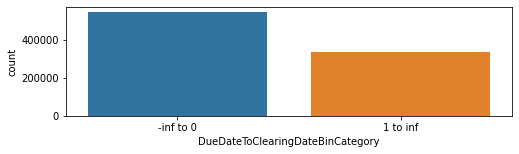

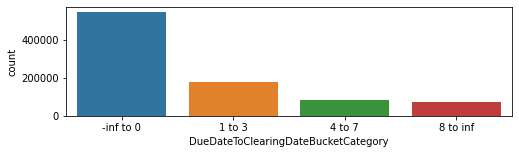

In [8]:
df, bin_class_names = setup_buckets(df, col='DueDateToClearingDate', bins=[1], sufix='Bin')
df, bucket_class_names = setup_buckets(df, col='DueDateToClearingDate', bins=[1, 4, 8], sufix='Bucket')

plot_countplot(df, cols=['DueDateToClearingDateBinCategory', 'DueDateToClearingDateBucketCategory'])

## Train and Test Data

In [ ]:
for x, y in zip(['PaidPastDocuments', 'PaidPastAmount', 'PastDueDocuments', 'PastDueAmount'],
                ['PaidDocuments', 'PaidAmount', 'OpenDocuments', 'OpenAmount']):
    df[f'Ratio{x}{y}'] = df[x] / df[y]
    df[f'Ratio{x}{y}'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df[[x, y, f'Ratio{x}{y}']] = df[[x, y, f'Ratio{x}{y}']].fillna(0)

df[['AvgPastDueDays', 'AvgDSOPastDueDocuments']] = df[['AvgPastDueDays', 'AvgDSOPastDueDocuments']].fillna(0)

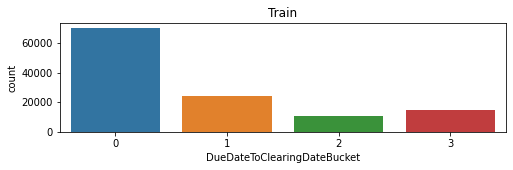

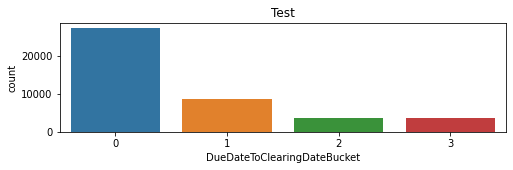

In [9]:
y_column = np.array(['DueDateToClearingDateBucket'])
x_column = np.array([
                    'AvgPastDueDays',
                    'AvgDSOPastDueDocuments',
                    'RatioPaidAmount',
                    'RatioInvoicedAmount',
                    'RatioOpenAmount',
                    'RatioPastDueAmount',
                    'RatioPaidPastAmount',
                    'DocumentAmount',
                    'DocumentDateToDueDate',
                        'CompanyKeyCategory',
                        'PaymentTermsCategory',
                        'CorporateDivisionCategory',
                        'CustomerKeyCategory',
                        'CustomerRegionCategory',
                    'DocumentDateDay',
                    'DueDateDay',
                    'DocumentDateWeekDay',
                    'DueDateWeekDay',
                    'DocumentDateDayOfYear',
                    'DueDateDayOfYear',


                    # 'AvgPastDueDays',
                    # 'AvgDSOPastDueDocuments',

                    # 'PaidDocuments',
                    # 'PaidPastDocuments',
                    # 'RatioPaidPastDocumentsPaidDocuments',

                    # 'PaidAmount',
                    # 'PaidPastAmount',
                    # 'RatioPaidPastAmountPaidAmount',
                     
                    # 'OpenDocuments',
                    # 'PastDueDocuments',
                    # 'RatioPastDueDocumentsOpenDocuments',

                    # 'OpenAmount',
                    # 'PastDueAmount',
                    # 'RatioPastDueAmountOpenAmount',

                    # 'DocumentAmount',
                    # 'DocumentDateToDueDate',

                    # 'CompanyKey',
                    # 'PaymentTerms',
                    # 'CorporateDivision',
                    # 'CustomerKey',
                    # 'CustomerRegion',

                    # 'DocumentDateDay',
                    # 'DueDateDay',
                    # 'DocumentDateWeekDay',
                    # 'DueDateWeekDay',
                    # 'DocumentDateDayOfYear',
                    # 'DueDateDayOfYear',
                    ])


train, test = split_data(df, date_column='DocumentDate', split_date='2020-07-01', train_months=3, test_months=1,
                         category_cols=['CompanyKey', 'CorporateDivision', 'CustomerKey', 'CustomerRegion', 'PaymentTerms'])

# train = resample(train, x_column, y_column, SMOTE(sampling_strategy='auto', random_state=SEED))

# 100:   75945
# 1000:  380664
# 10000: 309053
# train = train[train['CustomerKey'] == 380664]
# test = test[test['CustomerKey'] == 380664]

plot_countplot(train, cols=y_column, title='Train')
plot_countplot(test, cols=y_column, title='Test')

In [15]:
# train[(train['CustomerKey'] == 380664)][0::].head(15)

# train[(train['CustomerKey'] == 380664) & ((train['DocumentDate'] == '2020-05-13') | (train['DocumentDate'] == '2020-06-16'))]
test[(test['CustomerKey'] == 380664) & ((test['DocumentDate'] == '2020-07-09') | (test['DocumentDate'] == '2020-07-31'))]

,CompanyKey,CorporateDivision,CustomerKey,CustomerRegion,DocumentDate,DueDate,ClearingDate,PaymentTerms,DocumentNumber,DocumentAmount,InvoicedDocuments,InvoicedAmount,AvgInvoicedAmount,StdevInvoicedAmount,PaidDocuments,PaidAmount,AvgPaidAmount,StDevPaidAmount,PaidPastDocuments,PaidPastAmount,AvgPaidPastAmount,StDevPaidPastAmount,OpenDocuments,OpenAmount,AvgOpenAmount,StDevOpenAmount,PastDueDocuments,PastDueAmount,AvgPastDueAmount,StDevPastDueAmount,DSOPastDueDocuments,AvgDSOPastDueDocuments,StDevDSOPastDueDocuments,DSO,AvgDSO,StDevDSO,PastDueDays,AvgPastDueDays,StDevPastDueDays,DocumentDateToDueDate,DueDateToClearingDate,DocumentDateToClearingDate,RatioInvoicedAmount,RatioPaidAmount,RatioOpenAmount,RatioPastDueAmount,RatioPaidPastAmount,DocumentDateDay,DocumentDateWeekDay,DocumentDateMonth,DocumentDateDayOfYear,DueDateDay,DueDateWeekDay,DueDateMonth,DueDateDayOfYear,DueDateToClearingDateBinCategory,DueDateToClearingDateBin,DueDateToClearingDateBucketCategory,DueDateToClearingDateBucket,CompanyKeyCategory,CorporateDivisionCategory,CustomerKeyCategory,CustomerRegionCategory,PaymentTermsCategory
131102,41,JBS Pork Domestic,380664,SD,2020-07-09,2020-07-21,2020-08-04,JN07,965667492,15182.99,910.0,73092847.88,80321.811,47340.276,896.0,72093604.74,79223.741,47989.472,106.0,7915537.06,8698.3924,30963.987,14.0,999243.14,1098.0694,10596.699,110.0,8091939.25,8892.2409,31115.633,1959.0,2.152747,6.285276,7555.0,8.302198,4.696029,687.0,0.754945,2.939873,12,14,26,80321.810857,80461.612433,71374.51,73563.084091,74674.877925,9,3,7,191,21,1,7,203,1 to inf,1,8 to inf,3,24,9,949,116,35
131103,4,JBS Pork Domestic,380664,SD,2020-07-09,2020-07-21,2020-07-22,JN07,932398873,39330.00,910.0,73092847.88,80321.811,47340.276,896.0,72093604.74,79223.741,47989.472,106.0,7915537.06,8698.3924,30963.987,14.0,999243.14,1098.0694,10596.699,110.0,8091939.25,8892.2409,31115.633,1959.0,2.152747,6.285276,7555.0,8.302198,4.696029,687.0,0.754945,2.939873,12,1,13,80321.810857,80461.612433,71374.51,73563.084091,74674.877925,9,3,7,191,21,1,7,203,1 to inf,1,1 to 3,1,1,9,949,116,35
131104,41,JBS Pork Domestic,380664,SD,2020-07-09,2020-07-21,2020-07-23,JN07,932399808,31876.00,910.0,73092847.88,80321.811,47340.276,896.0,72093604.74,79223.741,47989.472,106.0,7915537.06,8698.3924,30963.987,14.0,999243.14,1098.0694,10596.699,110.0,8091939.25,8892.2409,31115.633,1959.0,2.152747,6.285276,7555.0,8.302198,4.696029,687.0,0.754945,2.939873,12,2,14,80321.810857,80461.612433,71374.51,73563.084091,74674.877925,9,3,7,191,21,1,7,203,1 to inf,1,1 to 3,1,24,9,949,116,35
131105,41,JBS Pork Domestic,380664,SD,2020-07-09,2020-07-21,2020-07-22,JN07,932399809,1170.00,910.0,73092847.88,80321.811,47340.276,896.0,72093604.74,79223.741,47989.472,106.0,7915537.06,8698.3924,30963.987,14.0,999243.14,1098.0694,10596.699,110.0,8091939.25,8892.2409,31115.633,1959.0,2.152747,6.285276,7555.0,8.302198,4.696029,687.0,0.754945,2.939873,12,1,13,80321.810857,80461.612433,71374.51,73563.084091,74674.877925,9,3,7,191,21,1,7,203,1 to inf,1,1 to 3,1,24,9,949,116,35
160893,41,JBS Pork Domestic,380664,SD,2020-07-31,2020-08-12,2020-08-19,JN07,932548107,8263.09,946.0,75910055.94,80243.188,47831.782,933.0,74902119.40,79177.716,48380.112,113.0,8157071.74,8622.6974,30584.377,13.0,1007936.54,1065.4720,10777.100,116.0,8222057.43,8691.3926,30590.355,2066.0,2.183932,6.292012,7926.0,8.378436,4.667406,710.0,0.750529,2.923925,12,7,19,80243.188097,80280.942551,77533.58,70879.805431,72186.475575,31,4,7,213,12,2,8,225,1 to inf,1,4 to 7,2,24,9,949,116,35
160920,4,JBS Pork Domestic,380664,SD,2020-07-31,2020-08-12,2020-08-06,JN07,932544555,24670.40,946.0,75910055.94,80243.188,47831.782,933.0,74902119.40,79177.716,48380.112,113.0,8157071.74,8622.6974,30584.377,13.0,1007936.54,1065.4720,10777.100,116.0,8222057.43,8691.3926,30590.355,2066.0,2.183932,6.292012,7926.0,8.378436,4.667406,710.0,0.750529,2.923925,12,-6,6,80243.188097,80280.942551,77533.58,70879.805431,72186.475575,31,4,7,213,12,2,8,225,-inf to 0,0,-inf to 0,0,1,9,949,116,35


In [11]:
train = train[(train['CustomerKey'] == 380664) & ((train['DocumentDate'] == '2020-05-13') | (train['DocumentDate'] == '2020-06-16'))]
test = test[(test['CustomerKey'] == 380664) & ((test['DocumentDate'] == '2020-07-09') | (test['DocumentDate'] == '2020-07-31'))]

## Data Analysis

In [ ]:
# x_train, y_train, x_test, y_test = preprocess_data(train, test, x_column, y_column)

# df_train = np.concatenate((x_train, y_train), axis=1)
# df_test = np.concatenate((x_test, y_test), axis=1)
# df_local = np.concatenate((df_train, df_test), axis=0)

# cols = np.concatenate((x_column, y_column), axis=0)
# df_local = pd.DataFrame(df_local, columns=cols)

# profile = ProfileReport(df_local)
# profile

## Random Forest

              precision    recall  f1-score   support

           0       1.00      0.00      0.00         1
           1       1.00      0.00      0.00         3
           2       1.00      0.00      0.00         1
           3       0.17      1.00      0.29         1

    accuracy                           0.17         6
   macro avg       0.79      0.25      0.07         6
weighted avg       0.86      0.17      0.05         6



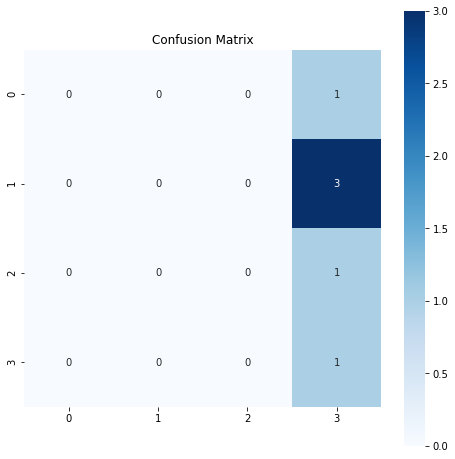

In [12]:
# from sklearn.model_selection import RandomizedSearchCV

# grid_param = {
#     'n_estimators': [50, 100, 250, 750],
#     'class_weight': ['balanced', 'balanced_subsample'],
#     # 'max_depth': [10, 25, 50, None],
#     # 'min_samples_split': [2, 10, 20],
#     # 'min_samples_leaf': [2, 10, 20],
# }

# x_train, y_train, x_test, y_test = preprocess_data(train, test, x_column, y_column)

# clf = RandomForestClassifier(criterion='entropy', random_state=SEED)
# rfr = RandomizedSearchCV(estimator=clf, param_distributions=grid_param, n_iter=100, cv=5, random_state=SEED, n_jobs=-1, verbose=2)

# rfr.fit(x_train, np.squeeze(y_train))
# print(rfr.best_params_)



x_train, y_train, x_test, y_test = preprocess_data(train, test, x_column, y_column)

clf = RandomForestClassifier(n_estimators=2, criterion='entropy', class_weight='balanced', random_state=SEED, n_jobs=-1)
clf.fit(x_train, np.squeeze(y_train))

y_predict = clf.predict(x_test)
plot_confuncion_matrix(test[y_column].values, y_predict)

Feature ranking:
0.375	CorporateDivisionCategory
0.35728166919925847	DueDateWeekDay
0.1427183308007415	DocumentAmount
0.125	RatioPaidPastAmount
0.0	DueDateDayOfYear
0.0	DocumentDateToDueDate
0.0	AvgDSOPastDueDocuments
0.0	RatioPaidAmount
0.0	RatioInvoicedAmount
0.0	RatioOpenAmount
0.0	RatioPastDueAmount
0.0	CompanyKeyCategory
0.0	DocumentDateDayOfYear
0.0	PaymentTermsCategory
0.0	CustomerKeyCategory
0.0	CustomerRegionCategory
0.0	DocumentDateDay
0.0	DueDateDay
0.0	DocumentDateWeekDay
0.0	AvgPastDueDays


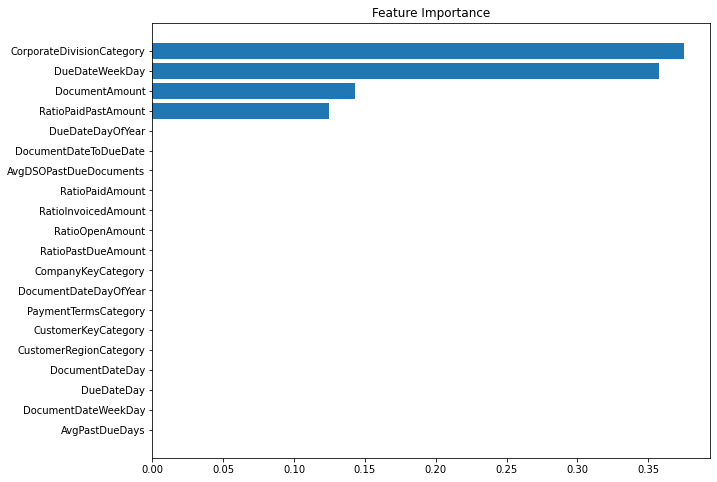

In [13]:
plot_feature_importance(x_column, clf.feature_importances_)

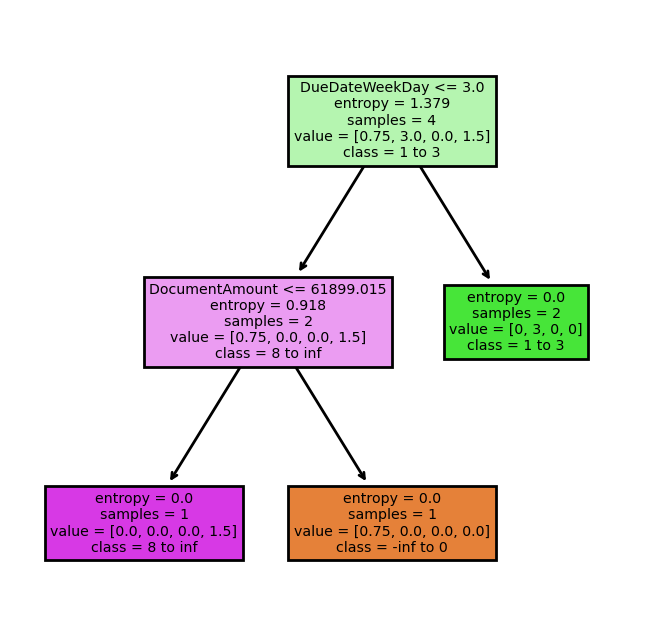

In [14]:
from sklearn import tree

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4), dpi=200)
tree.plot_tree(clf.estimators_[0], feature_names=x_column, class_names=bucket_class_names, filled=True);

In [ ]:
# y_predict = (clf.predict_proba(x_test)[:,1] >= 0.9999).astype('int')
# plot_confuncion_matrix(test[y_column].values, y_predict)

In [ ]:
# x_column = np.array([])

# score, features = features_selection(train, test, x_column, y_column, random_state=SEED)

# print(f'\nFinal score: {score:.8f} >>> {features}')

## Neural Network

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.model_selection import train_test_split

# import tensorflow_addons as tfa
# import tensorflow as tf

# def make_model():
#     model = tf.keras.models.Sequential(name='cubricks')
#     model.add(tf.keras.layers.Input(shape=x_train.shape[1]))

#     model.add(tf.keras.layers.Dense(256, kernel_initializer='glorot_normal'))
#     model.add(tf.keras.layers.PReLU())
#     model.add(tf.keras.layers.BatchNormalization(renorm=False))

#     model.add(tf.keras.layers.Dense(512, kernel_initializer='glorot_normal'))
#     model.add(tf.keras.layers.PReLU())
#     model.add(tf.keras.layers.BatchNormalization(renorm=False))

#     model.add(tf.keras.layers.Dense(256, kernel_initializer='glorot_normal'))
#     model.add(tf.keras.layers.PReLU())
#     model.add(tf.keras.layers.BatchNormalization(renorm=False))

#     # model.add(tf.keras.layers.Dense(32, kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-3, l2=1e-2)))
#     # model.add(tf.keras.layers.PReLU())
#     # model.add(tf.keras.layers.BatchNormalization(renorm=False))

#     # model.add(tf.keras.layers.Dense(64, kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-3, l2=1e-2)))
#     # model.add(tf.keras.layers.PReLU())
#     # model.add(tf.keras.layers.BatchNormalization(renorm=False))
#     # # model.add(tf.keras.layers.Dropout(rate=0.1))

#     # model.add(tf.keras.layers.Dense(128, kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-3, l2=1e-2)))
#     # model.add(tf.keras.layers.PReLU())
#     # model.add(tf.keras.layers.BatchNormalization(renorm=False))

#     model.add(tf.keras.layers.Dense(np.unique(y_train).shape[0], activation='softmax'))

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-8, amsgrad=True),
#         loss=tf.keras.losses.CategoricalCrossentropy(),
#         # loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
#         metrics=[tfa.metrics.F1Score(num_classes=np.unique(y_train).shape[0], average='weighted')])

#     return model


# model = make_model()
# model.summary()

# train, test = split_data_month_window(df, col='DueDate', date='2020-08-01', month_window=12)
# x_train, y_train, x_test, y_test = prepare_data(train, test, x_column, y_column, random_state=SEED)

# x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=SEED, stratify=y_train)

In [ ]:
# BATCH = 256
# EPOCHS = 10000
# PATIENCE = 10000

# tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs', profile_batch=0)

# checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='./logs/weights.hdf5',
#                                                 monitor='val_f1_score', mode='max',
#                                                 save_best_only=True, save_weights_only=True, verbose=1)

# early_stopping = tf.keras.callbacks.EarlyStopping(patience=PATIENCE,
#                                                   monitor='val_f1_score', mode='max',
#                                                   restore_best_weights=True, verbose=1)

# class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train[:,0])
# class_weight = dict(zip(np.unique(y_train), class_weight))

# model = make_model()
# # model.load_weights(filepath='./logs/weights.hdf5')

# model_history = model.fit(x_train, tf.keras.utils.to_categorical(y_train),
#                           validation_data=(x_valid, tf.keras.utils.to_categorical(y_valid)),
#                           epochs=EPOCHS, batch_size=BATCH, shuffle=True,
#                           callbacks=[checkpoint, early_stopping, tensorboard],
#                           class_weight=class_weight)

In [ ]:
# def plot_model_history(history):
#     colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
#     plt.figure(figsize=(15, 3))

#     for n, metric in enumerate(['loss', 'f1_score']):
#         plt.subplot(1, 2, n+1)
#         plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
#         plt.plot(history.epoch, history.history['val_' + metric], color=colors[0], linestyle='--', label='Val')
#         plt.ylim([plt.ylim()[0], 1] if n > 0 else [0, plt.ylim()[1]])
#         plt.ylabel(metric.replace('_', ' ').capitalize())
#         plt.xlabel('Epoch')
#         plt.legend()


# plot_model_history(model_history)

In [ ]:
# model.load_weights(filepath='./logs/weights.hdf5')

# y_predict = classifier_predict(model, x_test, threshold=0.5, network=True)
# plot_confuncion_matrix(y_test, y_predict)